# PDM vers PCM : Démodulation et Traitement du Signal

## Plan d'implémentation

1. Import des bibliothèques
2. Chargement et visualisation du signal PDM
3. Analyse spectrale du signal PDM
4. Conception du filtre FIR passe-bas
5. Analyse du filtre (pôles/zéros, Bode)
6. Filtrage et décimation
7. Normalisation et quantification
8. Comparaison avec le signal de référence



In [35]:
import scipy.io
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

# Paramètres
fs_pdm = 6_144_000  # Fréquence d'échantillonnage PDM
fs_pcm = 48_000     # Fréquence PCM cible



## 1. Chargement et visualisation du signal PDM



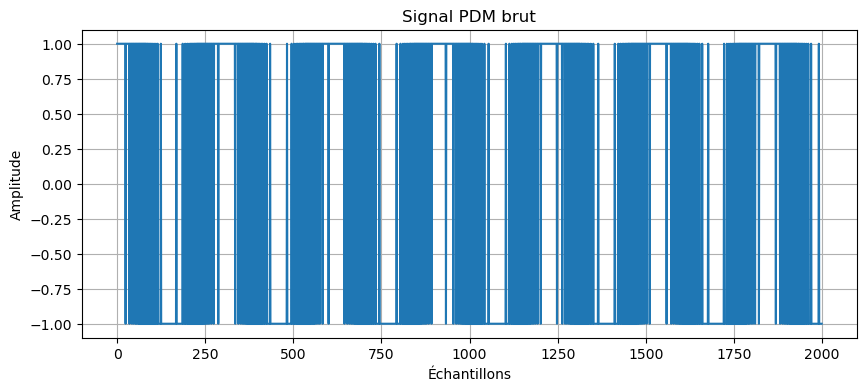

In [36]:
# Chargement du signal PDM
pdm = scipy.io.loadmat('./data/pdm_in.mat')['in'].reshape(-1)

plt.figure(figsize=(10, 4))
plt.plot(pdm[0:2000])
plt.title("Signal PDM brut")
plt.xlabel("Échantillons")
plt.ylabel("Amplitude")
plt.grid()
plt.show()



## 2. Analyse spectrale du signal PDM



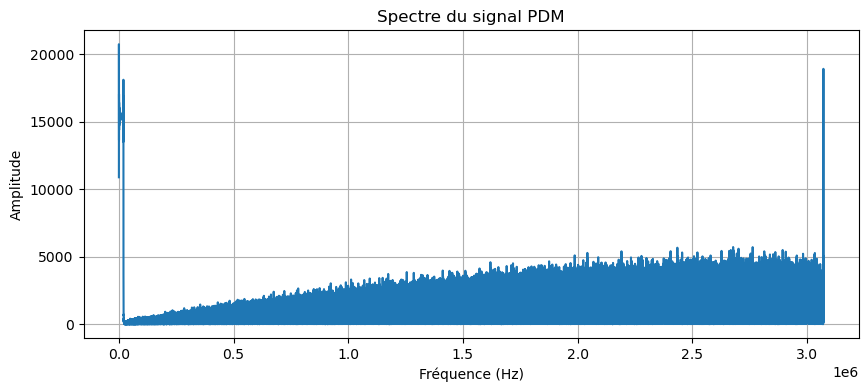

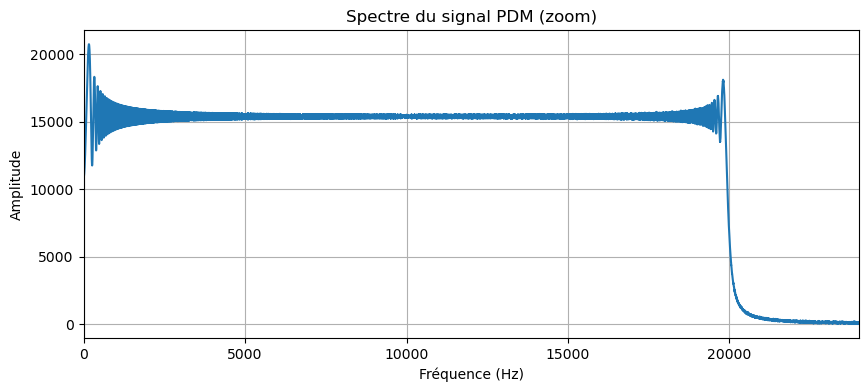

In [37]:
# FFT du signal PDM
pdm_fft = rfft(pdm.flatten())
freq = rfftfreq(len(pdm), 1/fs_pdm)

# Visualisation du spectre complet
plt.figure(figsize=(10, 4))
plt.plot(freq, np.abs(pdm_fft))
plt.title("Spectre du signal PDM")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Zoom sur les basses fréquences
plt.figure(figsize=(10, 4))
plt.plot(freq, np.abs(pdm_fft))
plt.xlim(0, fs_pcm//2)
plt.title("Spectre du signal PDM (zoom)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()



## 3. Conception du filtre FIR passe-bas



In [38]:
# Paramètres du filtre
cutoff = fs_pcm / (fs_pdm)  # Fréquence de coupure normalisée
num_taps = 101                 # Ordre du filtre
fir_coeff = signal.firwin(num_taps, cutoff, window='hamming', fs=fs_pdm)



## 4. Analyse du filtre



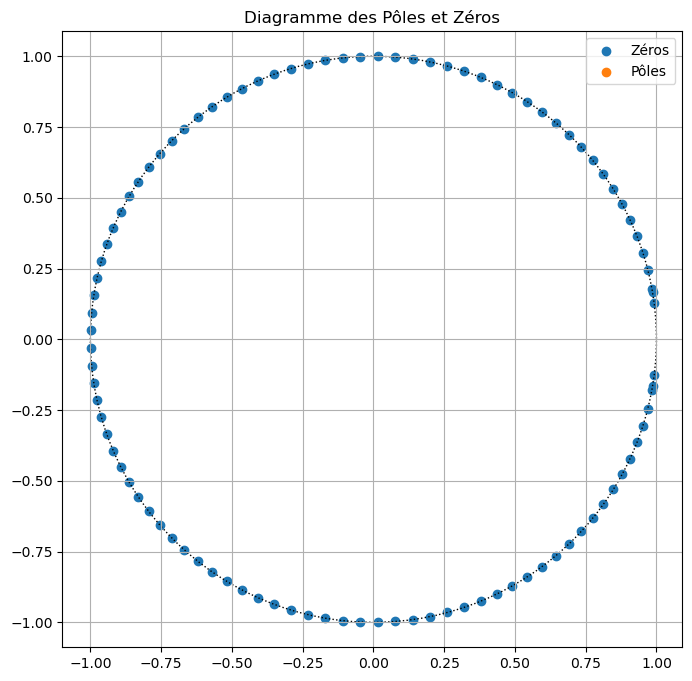

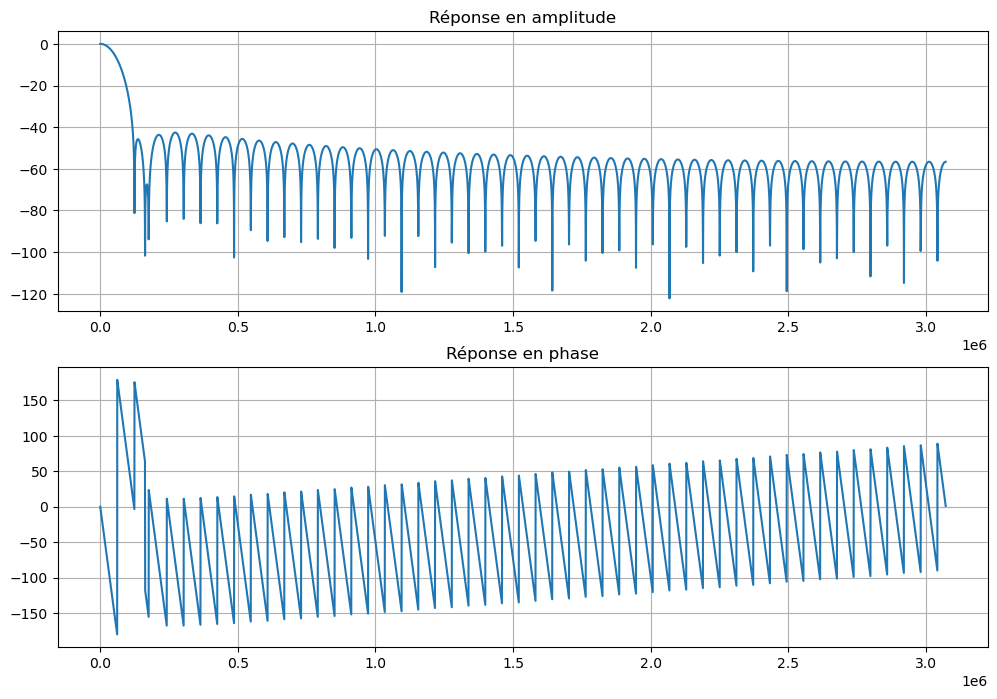

In [39]:
# Diagramme pôles/zéros
zeros, poles, gain = signal.tf2zpk(fir_coeff, [1.0])

plt.figure(figsize=(8, 8))
plt.scatter(np.real(zeros), np.imag(zeros), label="Zéros")
plt.scatter(np.real(poles), np.imag(poles), label="Pôles")
circle = plt.Circle((0, 0), 1, fill=False, linestyle='dotted')
plt.gca().add_artist(circle)
plt.grid(True)
plt.axis("equal")
plt.title("Diagramme des Pôles et Zéros")
plt.legend()
plt.show()

# Diagramme de Bode
w, h = signal.freqz(fir_coeff, worN=8000, fs=fs_pdm)
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(w, 20*np.log10(np.abs(h)))
plt.grid()
plt.title("Réponse en amplitude")
plt.subplot(212)
plt.plot(w, np.angle(h, deg=True))
plt.grid()
plt.title("Réponse en phase")
plt.show()



## 5. Filtrage et décimation



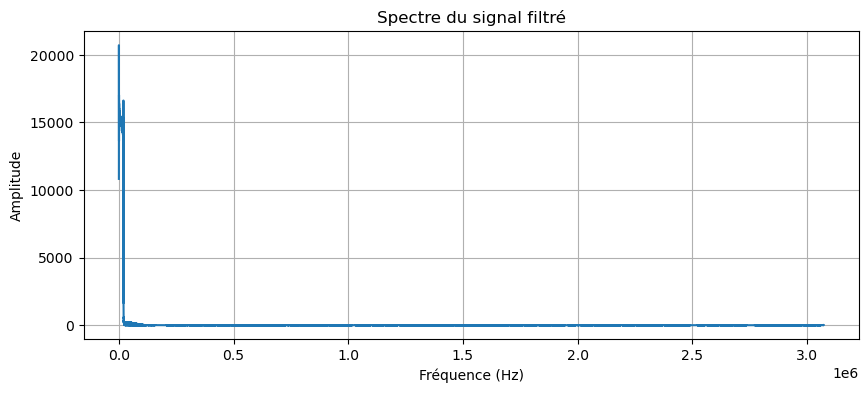

In [40]:
# Application du filtre
filtered_signal = signal.lfilter(fir_coeff, 1.0, pdm.flatten())
# FFT du signal filtré
filtered_signal_fft = rfft(filtered_signal)
freq_filtered = rfftfreq(len(filtered_signal), 1/fs_pdm)

# Visualisation du spectre du signal filtré
plt.figure(figsize=(10, 4))
plt.plot(freq_filtered, np.abs(filtered_signal_fft))
plt.title("Spectre du signal filtré")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

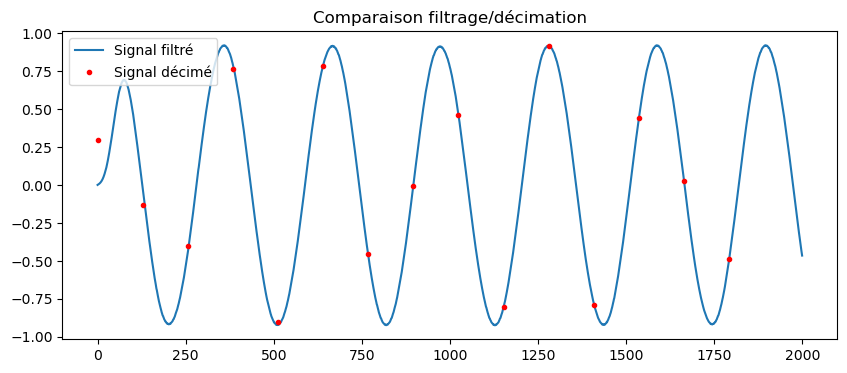

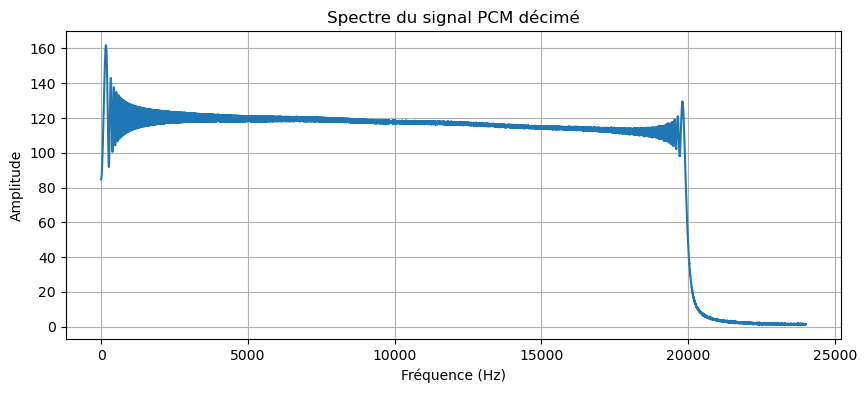

In [41]:


# Décimation
decimation_factor = fs_pdm // fs_pcm
pcm_signal = signal.decimate(filtered_signal, decimation_factor, ftype="fir")

# Visualisation
plt.figure(figsize=(10, 4))
plt.plot(filtered_signal[0:2000], label="Signal filtré")
plt.plot(np.arange(0, 2000, decimation_factor)[:len(pcm_signal[0:2000//decimation_factor])], 
         pcm_signal[0:2000//decimation_factor], 
         'r.', label="Signal décimé")
plt.title("Comparaison filtrage/décimation")
plt.legend()
plt.show()

# Spectre du signal PCM décimé
pcm_signal_fft = rfft(pcm_signal)
freq_pcm = rfftfreq(len(pcm_signal), 1/fs_pcm)

plt.figure(figsize=(10, 4))
plt.plot(freq_pcm, np.abs(pcm_signal_fft))
plt.title("Spectre du signal PCM décimé")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()



## 6. Normalisation et quantification



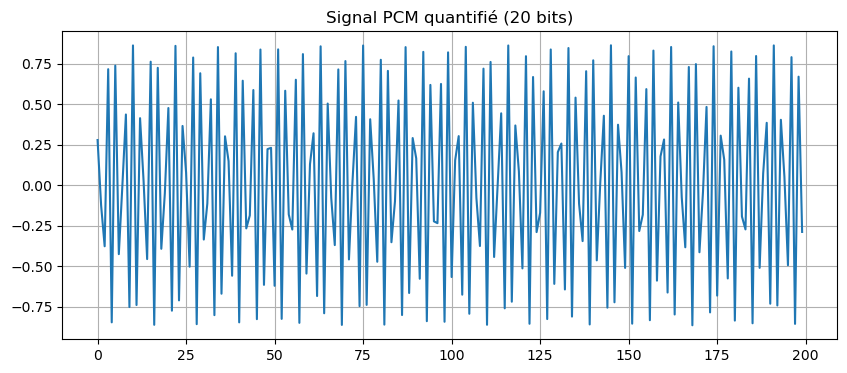

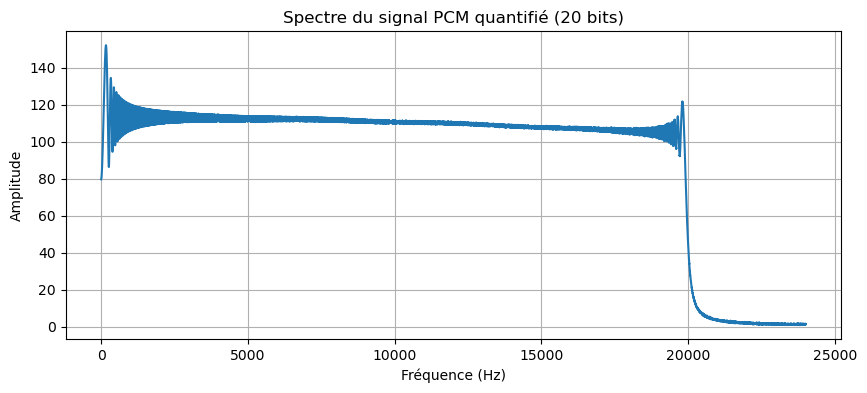

In [42]:
# Normalisation [-1, 1]
pcm_signal = pcm_signal / np.max(np.abs(pcm_signal))

# Quantification 20 bits
pcm_signal_20bit = np.round(pcm_signal * (2**19 - 1)).astype(np.int32)/(2**19 - 1)

plt.figure(figsize=(10, 4))
plt.plot(pcm_signal_20bit[0:200])
plt.title("Signal PCM quantifié (20 bits)")
plt.grid()
plt.show()

# Spectre du signal PCM quantifié (20 bits)
pcm_signal_20bit_fft = rfft(pcm_signal_20bit)
freq_pcm = rfftfreq(len(pcm_signal_20bit), 1/fs_pcm)

plt.figure(figsize=(10, 4))
plt.plot(freq_pcm, np.abs(pcm_signal_20bit_fft))
plt.title("Spectre du signal PCM quantifié (20 bits)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()



## 7. Comparaison



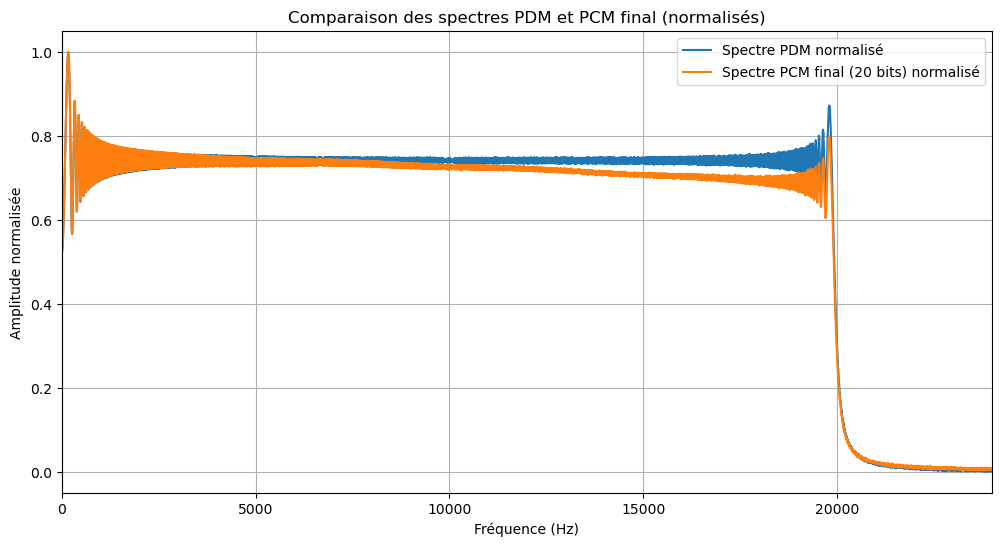

In [44]:
# Normalisation des spectres
pdm_fft_normalized = np.abs(pdm_fft) / np.max(np.abs(pdm_fft))
pcm_signal_20bit_fft_normalized = np.abs(pcm_signal_20bit_fft) / np.max(np.abs(pcm_signal_20bit_fft))

# Comparaison des spectres PDM et PCM final
plt.figure(figsize=(12, 6))

# Spectre du signal PDM
plt.plot(freq, pdm_fft_normalized, label="Spectre PDM normalisé")

# Spectre du signal PCM final
plt.plot(freq_pcm, pcm_signal_20bit_fft_normalized, label="Spectre PCM final (20 bits) normalisé")

plt.xlim(0, fs_pcm//2)
plt.title("Comparaison des spectres PDM et PCM final (normalisés)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude normalisée")
plt.legend()
plt.grid()
plt.show()




Ce notebook implémente une chaîne complète de démodulation PDM vers PCM avec analyse à chaque étape. Les visualisations permettent de comprendre l'effet de chaque traitement sur le signal.